In [8]:
import os
import math

import matplotlib
import numpy as np
import sys
import scipy
import yaml

sys.path.append('../')
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from matplotlib import cm

from slow_reservoir.model import RNN

%matplotlib inline

In [9]:
def make_signal(N, time_length, mu_min, mu_max, uncertainty=10, pre_sigma=3, fix=False):
    input_signals = np.zeros([N, time_length, 100])
    phi = np.linspace(-2, 2, 100)
    sigma_sq = 0.5
    target_list = np.zeros([N, 400])
    signal_mu_list = []
    
    for i in range(N):
        signal_input = np.zeros([time_length, 100])
        true_signal = np.random.normal(0, 0.2)
        g = 1
        signal_sigma = np.sqrt(1 / g) * 0.5
        signal_mu = np.random.normal(true_signal, signal_sigma)
        
        # signal
        signal_base = g * 1 * np.exp(-(signal_mu - phi) ** 2 / (2.0 * sigma_sq))
        for t in range(time_length):
            signal_input[t] = np.random.poisson(signal_base)
        
        input_signals[i] = signal_input
        signal_mu_list.append(signal_mu)
        
    return input_signals, signal_mu_list

In [19]:
config_path = '../slow_reservoir/trained_model/steady_state/20220325_2/20220325_2.cfg'
with open(config_path, 'r') as f:
    cfg = yaml.safe_load(f)
    

model_name = os.path.splitext(os.path.basename(config_path))[0]
print('model_name: ', model_name)

torch.manual_seed(1)
device = torch.device('cpu')

model = RNN(
        n_in=cfg['DATALOADER']['INPUT_NEURON'],
        n_out=1,
        n_hid=cfg['MODEL']['SIZE'],
        n_reservoir=cfg['MODEL']['RESERVOIR'],
        device=device,
        alpha_fast=cfg['MODEL']['ALPHA_FAST'],
        alpha_slow=cfg['MODEL']['ALPHA_SLOW'],
        sigma_neu=cfg['MODEL']['SIGMA_NEU'],
    ).to(device)

model_path = f'../slow_reservoir/trained_model/steady_state/{model_name}/epoch_20.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()



model_name:  20220325_2


RNN(
  (w_in): Linear(in_features=100, out_features=200, bias=True)
  (w_hh): Linear(in_features=200, out_features=200, bias=True)
  (w_out): Linear(in_features=200, out_features=1, bias=True)
  (w_fs): Linear(in_features=200, out_features=50, bias=True)
  (w_sf): Linear(in_features=50, out_features=200, bias=True)
  (w_reservoir): Linear(in_features=50, out_features=50, bias=True)
  (w_prior): Linear(in_features=50, out_features=100, bias=True)
)

In [20]:
sample_num = 1
input_signal, signal_mu_list = make_signal(
    sample_num, 
    time_length=300, 
    mu_min=-2,
    mu_max=2,
    uncertainty=0.5,
    pre_sigma=0,
    fix=False,
)

hidden_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['SIZE']))
hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device)                                                   

reservoir_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['RESERVOIR']))
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
        
inputs = torch.from_numpy(input_signal).float()                                               
inputs = inputs.to(device)                                                                             
hidden_list, outputs, prior_list = model(inputs, hidden, reservoir, 300)                                                     
neural_dynamics = hidden_list.cpu().detach().numpy()   


In [22]:
np.random.normal(0, 0.2, 10)

array([-0.07474899,  0.09590056, -0.1655451 , -0.183456  ,  0.23376883,
       -0.29225392, -0.21366702, -0.21727915, -0.3232589 , -0.06017791])

In [ ]:
np.random.normal(0, 0.2, 10)

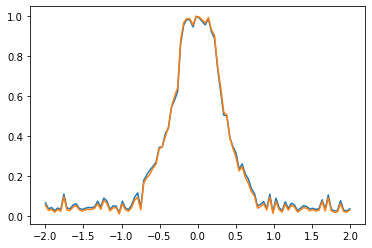

In [21]:
plt.plot(np.linspace(-2, 2, 100), prior_list[0, 30].detach().numpy())
plt.plot(np.linspace(-2, 2, 100), prior_list[0, 290].detach().numpy())

In [6]:
prior_list[0, -10:, 25:35]

tensor([[0.7633, 0.8512, 0.9228, 0.9946, 0.9986, 1.0000, 0.9895, 0.9358, 0.9799,
         0.7887],
        [0.7631, 0.8542, 0.9228, 0.9947, 0.9986, 1.0000, 0.9897, 0.9360, 0.9802,
         0.7886],
        [0.7639, 0.8546, 0.9234, 0.9948, 0.9987, 1.0000, 0.9898, 0.9371, 0.9805,
         0.7878],
        [0.7676, 0.8533, 0.9222, 0.9949, 0.9987, 1.0000, 0.9898, 0.9378, 0.9804,
         0.7872],
        [0.7659, 0.8537, 0.9230, 0.9949, 0.9987, 1.0000, 0.9899, 0.9389, 0.9807,
         0.7867],
        [0.7689, 0.8525, 0.9235, 0.9950, 0.9987, 1.0000, 0.9899, 0.9398, 0.9811,
         0.7877],
        [0.7693, 0.8545, 0.9259, 0.9952, 0.9988, 1.0000, 0.9902, 0.9407, 0.9814,
         0.7935],
        [0.7700, 0.8549, 0.9260, 0.9952, 0.9988, 1.0000, 0.9901, 0.9408, 0.9814,
         0.7931],
        [0.7712, 0.8553, 0.9264, 0.9951, 0.9988, 1.0000, 0.9901, 0.9409, 0.9816,
         0.7922],
        [0.7684, 0.8555, 0.9263, 0.9952, 0.9988, 1.0000, 0.9902, 0.9405, 0.9815,
         0.7947]], grad_fn=<

In [ ]:
def np_softmax(x):
    y = np.exp(x - np.max(x))
    f_x = y / np.sum(np.exp(x))
    
    f_x = np.exp(x) / np.sum(np.exp(x))
    return f_x

In [17]:
phi = np.linspace(-2, 2, cfg['DATALOADER']['INPUT_NEURON'])
tmp_likelihood = np.exp(-(0 - phi) ** 2 / (2.0 * (0.25**2)))

likelihood = tmp_likelihood / np.sum(tmp_likelihood)

In [15]:
target = np.exp(-(-0.8 - phi) ** 2 / (2.0 * (0.25**2)))
target /= np.sum(target)

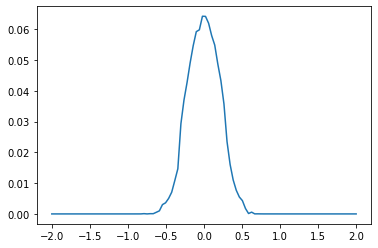

In [18]:
plt.plot(np.linspace(-2, 2, 100), likelihood*prior_list[0, 30].detach().numpy())

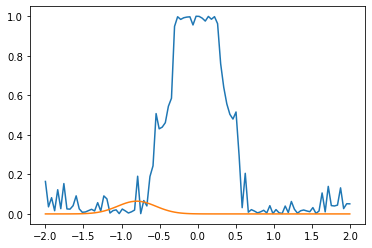

In [16]:
plt.plot(np.linspace(-2, 2, 100), prior_list[0, 30].detach().numpy())

plt.plot(np.linspace(-2, 2, 100), target)

In [ ]:
prior = prior_list[0, 30].detach().numpy()
plt.plot(np.linspace(-2, 2, 100), prior, label='prior')
# plt.plot(np.linspace(-2, 2, 100), likelihood, label='likelihood')
posterior = likelihood * prior
posterior = posterior / np.sum(likelihood * prior)

# plt.plot(np.linspace(-2, 2, 100), posterior, label='posterior')
plt.plot(np.linspace(-2, 2, 100), target, label='target')

plt.legend()

In [ ]:
np.argmax(prior)

In [ ]:
likelihood

In [ ]:
np.argmax(prior)

In [ ]:
np.argmax(likelihood)

In [ ]:
prior[0] * likelihood[0]

In [ ]:
prior[30] * likelihood[30]

In [ ]:
prior[95] * likelihood[95]

In [ ]:
np.argmax(posterior)

In [ ]:
posterior[np.argmax(posterior)]

In [ ]:
plt.plot(np.linspace(-2, 2, 100), np_softmax(prior_list[0, 30].detach().numpy()))

In [ ]:
prior_list[0, 30].detach().numpy()

In [ ]:
import seaborn as sns
sns.heatmap(input_signal[0, :])

In [ ]:
signal_mu_list[0]

In [ ]:
phi = np.linspace(-2, 2, 100)
tmp_likelihood1 = np.exp(-(1 - phi) ** 2 / (2.0 * (0.25**2)))
tmp_likelihood2 = np.exp(-(1 - phi) ** 2 / (2.0 * (0.5**2)))

In [ ]:
plt.plot(tmp_likelihood1 / np.sum(tmp_likelihood1))
plt.plot(tmp_likelihood2 / np.sum(tmp_likelihood2))